In [1]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import os
import pickle

In [2]:
np.random.seed(123)

In [3]:
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

## Utility functions

In [4]:
def save_history(history, fn):
    with open(fn, 'wb') as fw:
        pickle.dump(history.history, fw, protocol=2)

def load_history(fn):
    class Temp():
        pass
    history = Temp()
    with open(fn, 'rb') as fr:
        history.history = pickle.load(fr)
    return history

def plot_compare(history, steps=-1):
    if steps < 0:
        steps = len(history.history['accuracy'])
    accuracy = smooth_curve(history.history['accuracy'][:steps])
    val_accuracy = smooth_curve(history.history['val_accuracy'][:steps])
    loss = smooth_curve(history.history['loss'][:steps])
    val_loss = smooth_curve(history.history['val_loss'][:steps])

    plt.figure(figsize=(6, 4))
    plt.plot(loss, c='#0c7cba', label='Train Loss')
    plt.plot(val_loss, c='#0f9d58', label='Val Loss')
    plt.xticks(range(0, len(loss), 5))
    plt.xlim(0, len(loss))
    plt.title('Train Loss: %.3f, Val Loss: %.3f' % (loss[-1], val_loss[-1]), fontsize=12)
    plt.legend()

    plt.figure(figsize=(6, 4))
    plt.plot(accuracy, c='#0c7cba', label='Train Acc')
    plt.plot(val_accuracy, c='#0f9d58', label='Val Acc')
    plt.xticks(range(0, len(accuracy), 5))
    plt.xlim(0, len(accuracy))
    plt.title('Train Accuracy: %.3f, Val Accuracy: %.3f' % (accuracy[-1], val_accuracy[-1]), fontsize=12)
    plt.legend()

def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            previous = smoothed[-1]
            smoothed.append(previous * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

## Import the dataset

Clone from the github repo

In [8]:
#!git clone https://github.com/dbonacorsi/AML2021
!git clone https://github.com/dbonacorsi/AML2021/tree/main/datasets

Cloning into 'datasets'...
fatal: repository 'https://github.com/dbonacorsi/AML2021/tree/main/datasets/' not found


In [ ]:
!ls -trl

total 8
drwxr-xr-x 1 root root 4096 May 23 13:31 sample_data
drwxr-xr-x 4 root root 4096 May 25 10:32 AML2021


In [ ]:
!ls AML2021

AML_Adv_10_VAE.ipynb	    AML_Adv_6_MNIST_CNN.ipynb
AML_Adv_11_GAN.ipynb	    AML_Adv_7_ImageClass_CNN.ipynb
AML_Adv_12_PCA.ipynb	    AML_Adv_8_AE.ipynb
AML_Adv_13_NLP1.ipynb	    AML_Adv_9A_TimeSeries_persistence.ipynb
AML_Adv_14_NLP2.ipynb	    AML_Adv_9B_TimeSeries_MLP.ipynb
AML_Adv_1_DT.ipynb	    AML_Adv_9C_TimeSeries_CNN.ipynb
AML_Adv_2_SVM.ipynb	    AML_Adv_9D_TimeSeries_LSTM.ipynb
AML_Adv_3_Ensemble.ipynb    AML_Adv_9E_TimeSeries_CNN-LSTM.ipynb
AML_Adv_4_NNintro.ipynb     AML_Adv_9_RNN.ipynb
AML_Adv_5_MNIST_noNN.ipynb  datasets


In [ ]:
!ls AML2021/datasets/

cats_and_dogs_small  metamorphosis.txt	monthly-car-sales.csv


In [ ]:
!pwd

/content


# Data generator

In [ ]:
base_dir = '/content/AML2021/datasets/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Model creation

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1',
                 input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2), name='maxpool_1'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'))
model.add(MaxPooling2D((2, 2), name='maxpool_2'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'))
model.add(MaxPooling2D((2, 2), name='maxpool_3'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_4'))
model.add(MaxPooling2D((2, 2), name='maxpool_4'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', name='dense_1'))
model.add(Dense(256, activation='relu', name='dense_2'))
model.add(Dense(1, activation='sigmoid', name='output'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
%%time
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=20,
                              validation_data=validation_generator, validation_steps=50, verbose=1)

<timed exec>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
100/100 [==============================] - 26s 120ms/step - loss: 0.6963 - accuracy: 0.5200 - val_loss: 0.6906 - val_accuracy: 0.5260
Epoch 2/20
100/100 [==============================] - 12s 118ms/step - loss: 0.6940 - accuracy: 0.4990 - val_loss: 0.6928 - val_accuracy: 0.5300
Epoch 3/20
100/100 [==============================] - 11s 108ms/step - loss: 0.6912 - accuracy: 0.5140 - val_loss: 0.6878 - val_accuracy: 0.5020
Epoch 4/20
100/100 [==============================] - 11s 107ms/step - loss: 0.6901 - accuracy: 0.5285 - val_loss: 0.6810 - val_accuracy: 0.5650
Epoch 5/20
100/100 [==============================] - 11s 108ms/step - loss: 0.6886 - accuracy: 0.5175 - val_loss: 0.6803 - val_accuracy: 0.5490
Epoch 6/20
100/100 [==============================] - 11s 107ms/step - loss: 0.6839 - accuracy: 0.5365 - val_loss: 0.6819 - val_accuracy: 0.5480
Epoch 7/20
100/100 [==============================] - 12s 119ms/step - loss: 0.6719 - accuracy: 0.5710 - val_loss: 0.6725 - val_ac

In [ ]:
model.save('model.h5')
save_history(history, 'history.bin')

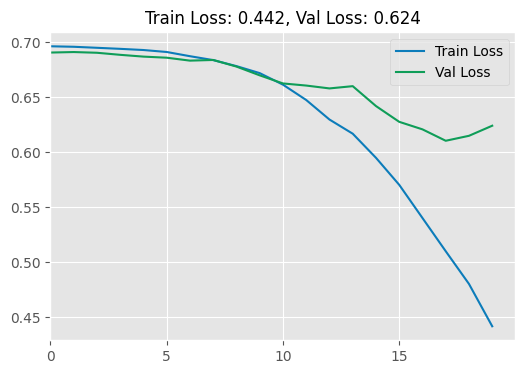

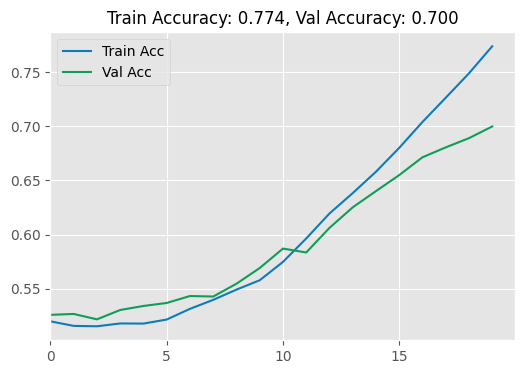

In [ ]:
history = load_history('history.bin')
plot_compare(history)